In [1]:
import os, glob
import numpy as np
from math import sqrt, ceil

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d .art3d import Poly3DCollection
from tqdm.auto import tqdm
from PIL import Image
import pyvista as pv

import mitsuba as mi
import trimesh
from trimesh.ray.ray_pyembree import RayMeshIntersector
from scipy.spatial import Delaunay

from collections import defaultdict

mi.set_variant("scalar_rgb") 

# Utility Funcitons

In [2]:
def visualize_triangles(triangles):
    vertices = triangles.reshape(-1, 3)
    faces = np.hstack([[3] + list(f) for f in np.arange(len(vertices)).reshape(-1, 3)])
    
    mesh = pv.PolyData(vertices, faces)
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, color='skyblue', show_edges=True, opacity=0.9)
    plotter.show()

In [3]:
def plotPointsViaDelaunayTriangulation(pnts):
    from scipy.spatial import Delaunay
    points = np.array(pnts)
    tri = Delaunay(points)
    plt.figure(dpi=300)
    plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), linewidth=0.5)
    plt.plot(points[:,0], points[:,1], 'o', ms=3)
    plt.show()

## Refining Triangles

In [4]:
def triangle_info(triangle):
    v0, v1, v2 = triangle
    centroid = (v0 + v1 + v2) / 3
    normal = np.cross(v1 - v0, v2 - v0)
    normal = normal / np.linalg.norm(normal)
    area = 0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0))
    return centroid, normal, area

In [5]:
def project_triangle_2D(triangle):
    v0, v1, v2 = triangle
    
    origin = v0

    u = v1 - v0
    u /= np.linalg.norm(u)
    
    normal = np.cross(v1 - v0, v2 - v0)
    normal /= np.linalg.norm(normal)
    
    v = np.cross(normal, u)
    
    def project_to_2d(p):
        relative = p - origin
        return [np.dot(relative, u), np.dot(relative, v)]
    
    v0_2d = project_to_2d(v0)  # will be (0, 0)
    v1_2d = project_to_2d(v1)
    v2_2d = project_to_2d(v2)

    return v0_2d, v1_2d, v2_2d, origin, u, v

In [6]:
def splitViaDelaunay(points, maxLength):
    # print("Perform Delaunay triangulation with "+str(len(points))+" points")
    tri = Delaunay(points)
    # get set of edges from the simpleces
    edges = set()
    for simplex in tri.simplices:
        # simplex is one triangle: [ 4  5 17]
        edges.add((simplex[0], simplex[1]))
        edges.add((simplex[1], simplex[2]))
        edges.add((simplex[0], simplex[2]))
    # check if all edges are small enough
    # and add new points if not
    isFinished = True
    for edge in edges:
        p1, p2 = edge
        [x1, y1] = points[p1]
        [x2, y2] = points[p2]
        length = sqrt((x2-x1)*(x2-x1)+(y2-y1)*(y2-y1))
        if length > maxLength:
            isFinished = False
            # split in how many pieces?
            nPieces = ceil(length/maxLength)
            for piece in range(1, int(nPieces)):
                points.append([x1+piece/float(nPieces)*(x2-x1), y1+piece/float(nPieces)*(y2-y1)])
    # plotPointsViaDelaunayTriangulation(points)
    if not isFinished:
        splitViaDelaunay(points, maxLength)

In [7]:
def subdivide_triangles(triangles, maxLength = 0.5):
    refined_triangles = []
    
    for triangle in tqdm(triangles, desc="Refinig Triangles", leave=False):
        v0_2d, v1_2d, v2_2d, origin, u, v = project_triangle_2D(triangle)
        points = [v0_2d, v1_2d, v2_2d]
        
        splitViaDelaunay(points, maxLength)  
        tri = Delaunay(points)
    
        def to_3d(p, origin, u, v):
            x, y = p
            return origin + u * x + v * y
            
        
        for x, y, z in tri.simplices:
            v0, v1, v2 = points[x], points[y], points[z]
            v0, v1, v2 = to_3d(v0, origin, u, v), to_3d(v1, origin, u, v), to_3d(v2, origin, u, v)
            refined_triangles.append([v0, v1, v2])
    
    return refined_triangles

In [8]:
def refine_scene(scene, maxLength=0.5):
    refined_scene = trimesh.Scene()
    
    for key, mesh in scene.geometry.items():
        triangles = mesh.triangles  # (N, 3, 3)
    
        refined_triangles = subdivide_triangles(triangles, maxLength)
    
        # Build new vertices and faces
        vertices = np.array(refined_triangles).reshape(-1, 3)
        faces = np.arange(len(vertices)).reshape(-1, 3)
    
        # Preserve visual/material if present
        mat = mesh.visual.material if hasattr(mesh.visual, 'material') else None
        print(mat)
        visual = trimesh.visual.TextureVisuals(material=mat) if mat else None
    
        new_mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, visual=visual)

        refined_scene.add_geometry(new_mesh, node_name=key)
    
    return refined_scene

# Code

In [9]:
filename = "CornellBox-Sphere.obj"
scene = trimesh.load("./radiosity/scenes/" + filename, force='scene')  # 'force=scene' is important if multiple geometries exist
triangles = scene.triangles

scene.geometry.keys()

odict_keys(['light', 'leftWall', 'rightWall', 'backWall', 'ceiling', 'floor', 'rightSphere', 'leftSphere'])

In [10]:
visualize_triangles(scene.triangles)

Widget(value='<iframe src="http://localhost:52582/index.html?ui=P_0x273d22b6c90_0&reconnect=auto" class="pyvis…

In [11]:
def refine_scene(scene, maxLength=0.5):
    refined_scene = trimesh.Scene()
    
    for key, mesh in scene.geometry.items():
        triangles = mesh.triangles  # (N, 3, 3)
    
        refined_triangles = subdivide_triangles(triangles, maxLength)
    
        # Build new vertices and faces
        vertices = np.array(refined_triangles).reshape(-1, 3)
        faces = np.arange(len(vertices)).reshape(-1, 3)
    
        # Preserve visual/material if present
        mat = mesh.visual.material if hasattr(mesh.visual, 'material') else None
        visual = trimesh.visual.TextureVisuals(material=mat) if mat else None
    
        new_mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False, visual=visual)
        new_mesh.name = key
        refined_scene.add_geometry(new_mesh, node_name=key)
    
    return refined_scene

refined_scene = refine_scene(scene, maxLength=0.5)
refined_scene.export("refined_scene.obj")
print("Exported Refined object File")

Refinig Triangles:   0%|          | 0/2 [00:00<?, ?it/s]

Refinig Triangles:   0%|          | 0/2 [00:00<?, ?it/s]

Refinig Triangles:   0%|          | 0/2 [00:00<?, ?it/s]

Refinig Triangles:   0%|          | 0/2 [00:00<?, ?it/s]

Refinig Triangles:   0%|          | 0/2 [00:00<?, ?it/s]

Refinig Triangles:   0%|          | 0/2 [00:00<?, ?it/s]

Refinig Triangles:   0%|          | 0/1088 [00:00<?, ?it/s]

Refinig Triangles:   0%|          | 0/1088 [00:00<?, ?it/s]

Exported Refined object File


In [12]:
visualize_triangles(refined_scene.triangles)

Widget(value='<iframe src="http://localhost:52582/index.html?ui=P_0x273fe7ae850_1&reconnect=auto" class="pyvis…

## Triangulation

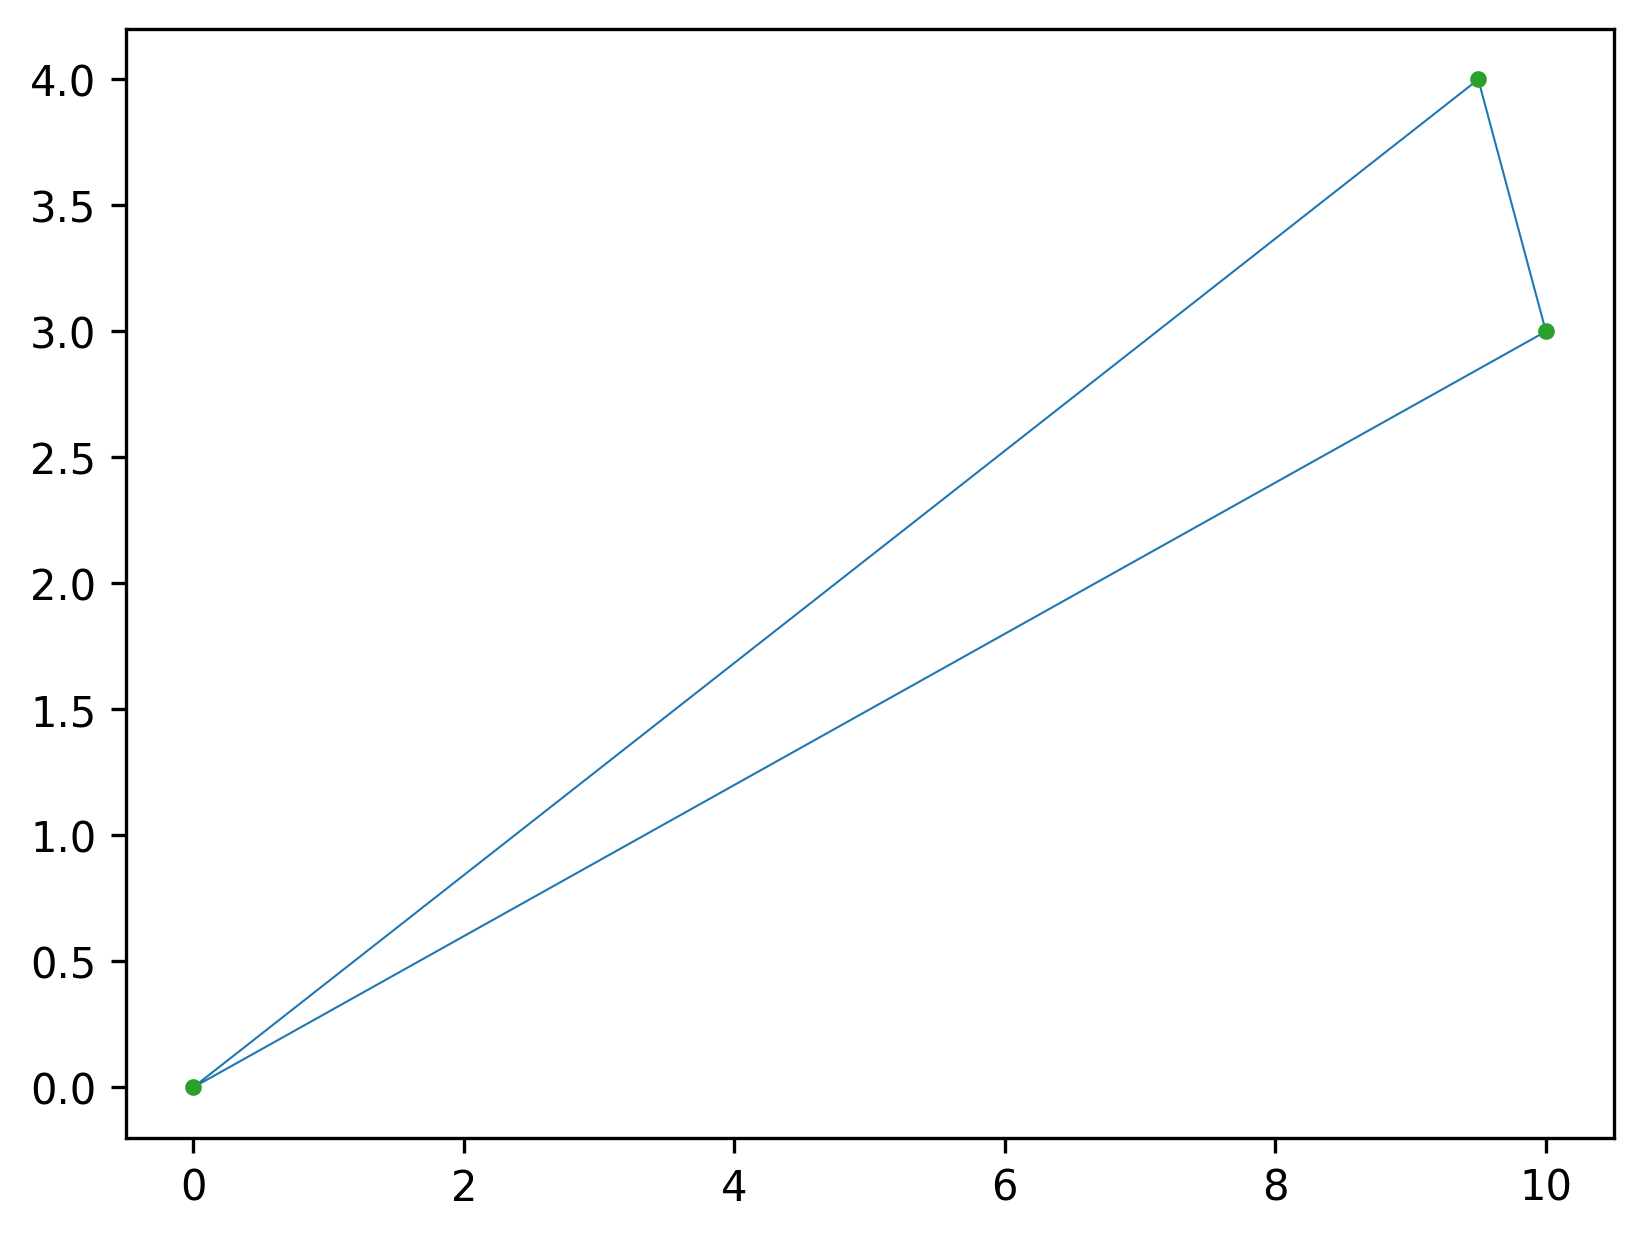

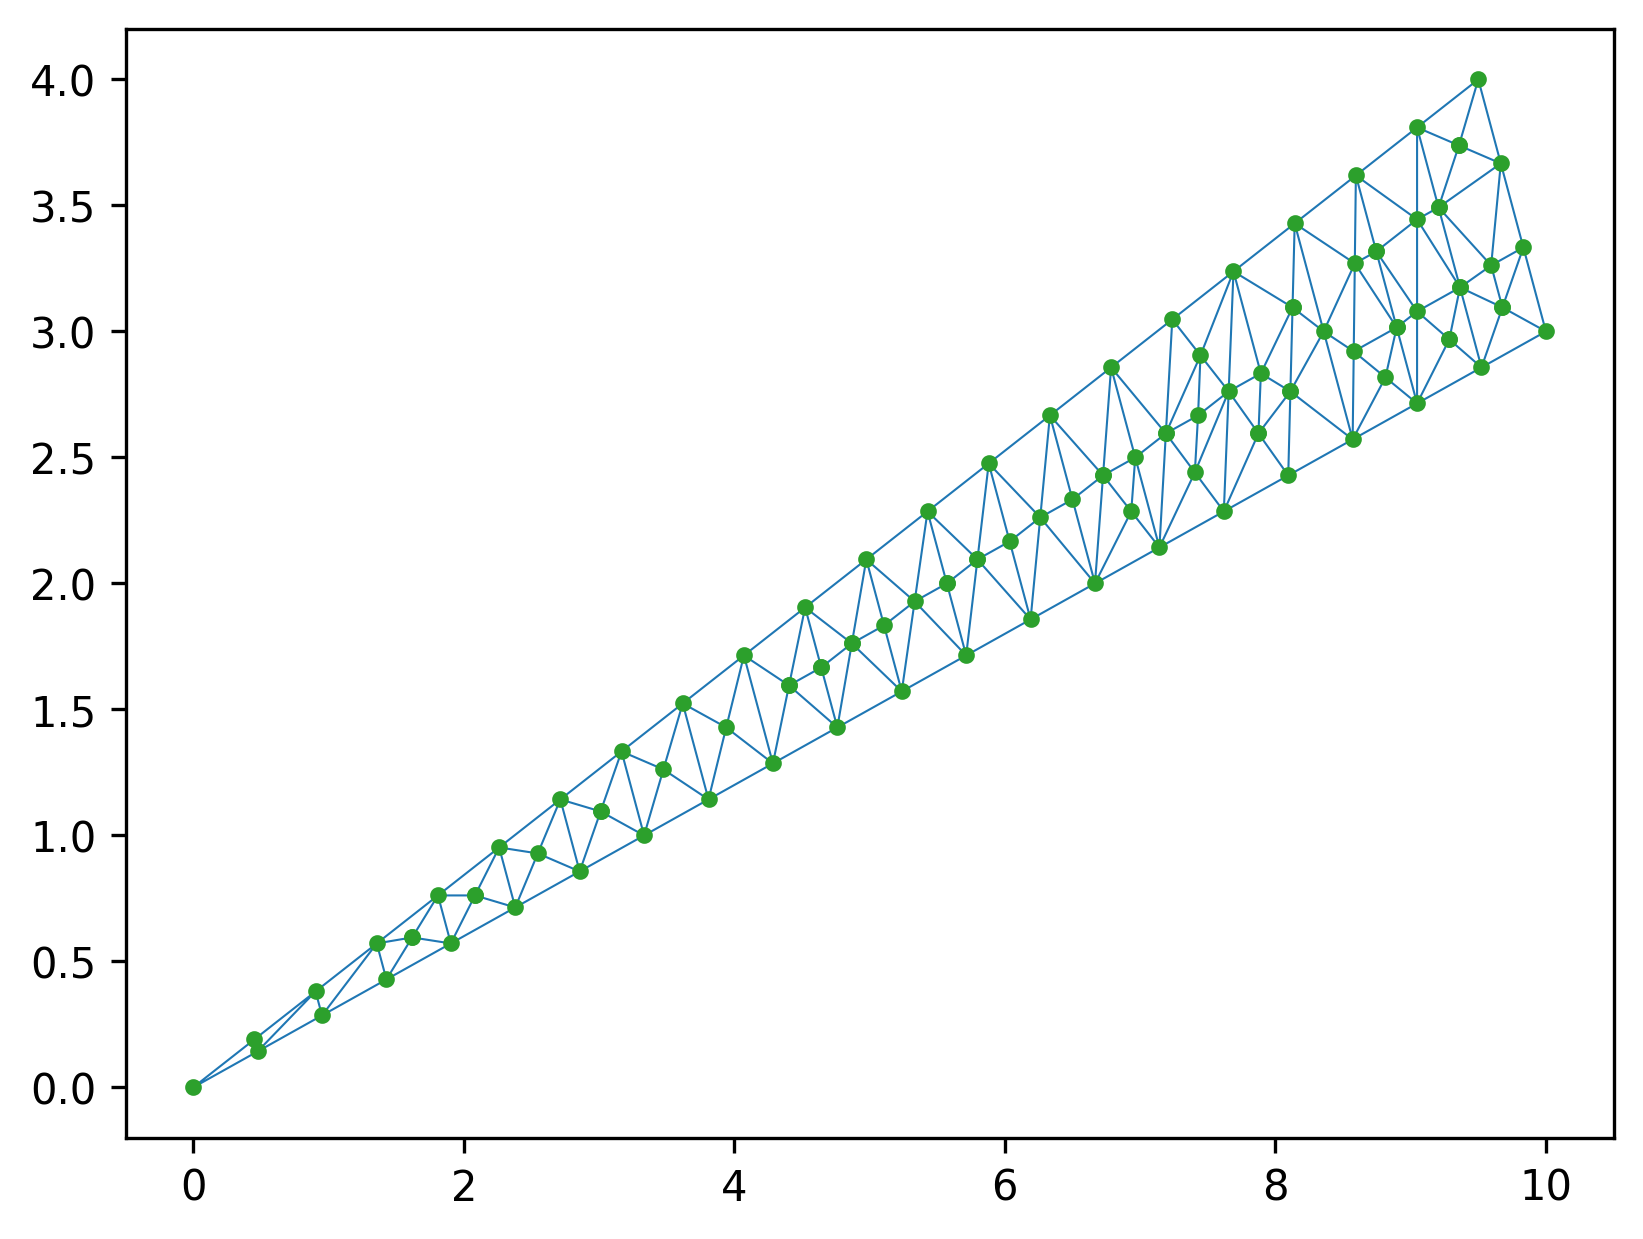

In [13]:
%matplotlib inline

points = [[0,0], [10,3], [9.5,4]]
plotPointsViaDelaunayTriangulation(points)
splitViaDelaunay(points, 0.5)
plotPointsViaDelaunayTriangulation(points)

## 

In [14]:
class Triangle:
    def __init__(self, points):
        self.vertices = points
        self.centroid, self.normal, self.area = triangle_info(self.vertices)
    def __repr__(self):
        return f"Triangle({self.vertices})"

    @staticmethod
    def from_array(arr):
        return [Triangle(t) for t in arr]

In [15]:
T = []
rho = []  # Reflectance
E = []    # Emission

for key, mesh in tqdm(refined_scene.geometry.items(), 'Extracting triangles'):
    N = len(mesh.triangles)
    T.extend(mesh.triangles)

    props = mesh.visual.material.kwargs

    kd = np.array(props.get('kd', [0.5, 0.5, 0.5]), dtype=np.float32)
    ke = np.array(props.get('ke', [0.0, 0.0, 0.0]), dtype=np.float32)

    rho.extend([kd] * N)
    E.extend([ke] * N)

T = np.array(Triangle.from_array(T))
rho = np.array(rho)
E = np.array(E)

T.shape, rho.shape, E.shape

Extracting triangles:   0%|          | 0/8 [00:00<?, ?it/s]

((2572,), (2572, 3), (2572, 3))

In [16]:
N = len(T)
# Flatten all triangles into one mesh for ray casting
all_faces = []
all_vertices = []

# Map triangle index to global face index
triangle_face_map = []

v_idx = 0
for tri in T:
    all_vertices.extend(tri.vertices)
    all_faces.append([v_idx, v_idx + 1, v_idx + 2])
    triangle_face_map.append((v_idx, v_idx + 1, v_idx + 2))
    v_idx += 3

scene_mesh = trimesh.Trimesh(vertices=all_vertices, faces=all_faces, process=False)

In [17]:
# N = len(T)
# rho = np.array(rho)
# E = np.array(E)

# centroids = np.array([tri.centroid for tri in T])
# normals = np.array([tri.normal for tri in T])
# areas = np.array([tri.area for tri in T])

# F = np.zeros((N, N))
# V = np.zeros((N, N), dtype=np.uint8)

# epsilon = 1e-4
# scene_rays = RayMeshIntersector(scene_mesh)

# for i in tqdm(range(N), desc="Calculating Visibility and Form Factors"):
#     origin = centroids[i]
#     normal_i = normals[i]

#     vecs_ij = centroids - origin
#     distances = np.linalg.norm(vecs_ij, axis=1)
#     directions = vecs_ij / distances[:, None]

#     cos_theta_i = directions @ normal_i
#     cos_theta_j = -np.einsum('ij,ij->i', directions, normals)

#     valid = (cos_theta_i > 0) & (cos_theta_j > 0)
#     valid[i] = False  # skip self

#     ray_origins = origin + epsilon * directions[valid]
#     ray_directions = directions[valid]
#     j_indices = np.where(valid)[0]

#     # Perform batched ray casting
#     locations, index_ray, index_tri = scene_rays.intersects_location(
#         ray_origins=ray_origins,
#         ray_directions=ray_directions,
#         multiple_hits=False
#     )

#     # Mark all initially visible
#     is_visible = np.ones_like(j_indices, dtype=bool)

#     # If any hits, check distance to detect obstruction
#     if len(locations) > 0:
#         for k, loc in enumerate(locations):
#             dist_to_hit = np.linalg.norm(loc - ray_origins[k])
#             if dist_to_hit < distances[j_indices[k]] - epsilon:
#                 is_visible[k] = False

#     visible_j = j_indices[is_visible]
#     for j in visible_j:
#         V[i, j] = 1
#         F[i, j] = (cos_theta_i[j] * cos_theta_j[j]) / (np.pi * distances[j] ** 2) * areas[j]

In [18]:
from scipy.spatial import cKDTree


F_path = f"./temp/{filename}_{N}_F.npy"
V_path = f"./temp/{filename}_{N}_V.npy"

if os.path.exists(F_path) and os.path.exists(V_path):
    print("Loading existing form factor and visibility matrices...")
    F = np.load(F_path)
    V = np.load(V_path)
else:
    print("Computing form factor and visibility matrices...")

    N = len(T)
    rho = np.array(rho)
    E = np.array(E)

    centroids = scene_mesh.triangles_center
    normals = scene_mesh.face_normals
    areas = scene_mesh.area_faces

    F = np.zeros((N, N))
    V = np.zeros((N, N), dtype=np.uint8)

    scene_rays = RayMeshIntersector(scene_mesh)

    # Build KD-tree on triangle centroids
    centroid_tree = cKDTree(centroids)

    from scipy.spatial.distance import pdist
    from numpy.linalg import norm

    bbox_min = np.min(centroids, axis=0)
    bbox_max = np.max(centroids, axis=0)

    max_neighbor_radius = norm(bbox_max - bbox_min)  # diagonal of bounding box

    epsilon = 1e-5 * np.linalg.norm(bbox_max - bbox_min)

    for i in tqdm(range(N), desc="Fast Visibility with cKDTree"):
        origin = centroids[i]
        normal_i = normals[i]

        # Nearby candidates only
        neighbors = centroid_tree.query_ball_point(origin, r=max_neighbor_radius)
        neighbors = [j for j in neighbors if j != i]

        if not neighbors:
            continue

        vecs = centroids[neighbors] - origin
        distances = np.linalg.norm(vecs, axis=1)
        directions = vecs / distances[:, None]

        cos_theta_i = directions @ normal_i
        cos_theta_j = -np.einsum('ij,ij->i', directions, normals[neighbors])

        valid_mask = (cos_theta_i > -10) & (cos_theta_j > -10)
        if not np.any(valid_mask):
            continue

        j_indices = np.array(neighbors)[valid_mask]
        dirs = directions[valid_mask]
        dists = distances[valid_mask]
        cos_i = abs(cos_theta_i[valid_mask])
        cos_j = abs(cos_theta_j[valid_mask])
        origins = origin + epsilon * dirs

        # Batched ray casting (no multiple hits)
        locations, index_ray, index_tri = scene_rays.intersects_location(
            ray_origins=origins,
            ray_directions=dirs,
            multiple_hits=False
        )

        # All initially visible
        is_visible = np.ones(len(j_indices), dtype=bool)

        # Mark obstructed rays
        if len(locations) > 0:
            hit_dists = np.linalg.norm(locations - origins[index_ray], axis=1)
            expected_dists = dists[index_ray]
            blocked = hit_dists < expected_dists - epsilon
            is_visible[index_ray[blocked]] = False

        visible_j = j_indices[is_visible]
        cos_i = cos_i[is_visible]
        cos_j = cos_j[is_visible]
        dists = dists[is_visible]

        F[i, visible_j] = (cos_i * cos_j) / (np.pi * dists ** 2) * areas[visible_j]
        V[i, visible_j] = 1

                # Save after computing
    np.save(F_path, F)
    np.save(V_path, V)
    print("Saved form factor and visibility matrices.")

Loading existing form factor and visibility matrices...


In [19]:
# for i in tqdm(range(N)):
#     visible_js = np.where(V[i] == 1)[0]
#     if len(visible_js) == 0:
#         continue

#     origin = centroids[i]
#     normal_i = normals[i]

#     targets = centroids[visible_js]
#     vecs_ij = targets - origin  # shape: (M, 3)
#     r = np.linalg.norm(vecs_ij, axis=1)
#     dir_ij = vecs_ij / r[:, None]

#     cos_theta_i = dir_ij @ normal_i
#     cos_theta_j = -np.einsum('ij,ij->i', dir_ij, normals[visible_js])

#     valid = (cos_theta_i > 0) & (cos_theta_j > 0)
#     if not np.any(valid):
#         continue

#     j_valid = visible_js[valid]
#     r_valid = r[valid]
#     cos_theta_i_valid = cos_theta_i[valid]
#     cos_theta_j_valid = cos_theta_j[valid]
#     area_j_valid = areas[j_valid]

#     F[i, j_valid] = (cos_theta_i_valid * cos_theta_j_valid) / (np.pi * r_valid ** 2) * area_j_valid


F_path = f"./temp/{filename}_{N}_F.npy"
V_path = f"./temp/{filename}_{N}_V.npy"

if os.path.exists(F_path) and os.path.exists(V_path):
    print("Loading existing form factor and visibility matrices...")
    F = np.load(F_path)
    V = np.load(V_path)
else:
    print("Computing form factor and visibility matrices...")

    # Save after computing
    np.save(F_path, F)
    np.save(V_path, V)
    print("Saved form factor and visibility matrices.")

Loading existing form factor and visibility matrices...


In [20]:
visualize_triangles(scene_mesh.triangles)

Widget(value='<iframe src="http://localhost:52582/index.html?ui=P_0x2738b3b4ed0_2&reconnect=auto" class="pyvis…

In [21]:
F = np.array(F)
V = np.array(V)
rho = np.array(rho)
E = np.array(E)

F_sum = F.sum(axis=1, keepdims=True)
F_sum[F_sum == 0] = 1  # prevent div-by-zero
F /= F_sum

F.shape, V.shape, rho.shape, E.shape

((2572, 2572), (2572, 2572), (2572, 3), (2572, 3))

In [22]:
# num_iterations = 25
# B = np.zeros_like(E)

# for _ in tqdm(range(num_iterations), "Radiosity Passes : "):
#     B_prev = B.copy()
#     for c in range(3):
#         R_c = np.diag(rho[:, c])
#         B[:, c] = E[:, c] + R_c @ (F @ B_prev[:, c])


# scene_dict = prepare_scene(T, B)
# render_scene(scene_dict, f"radiosity_{_}.png")
# print("Radiosity calculation complete.")

In [23]:
def prepare_scene(T, B):
    scene_dict = {}

    files = glob.glob("./temp/*.obj", recursive=True)
    for file in files: os.remove(file)
    
    for i in range(N):
        v0, v1, v2 = T[i].vertices if hasattr(T[i], 'vertices') else T[i]
        radiance = B[i]  # e.g., np.array([1.0, 0.5, 0.2])
        
        # Create triangle mesh
        vertices = np.array([v0, v1, v2])
        faces = np.array([[0, 1, 2]])
        triangle_mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)
    
        # Export the triangle to an OBJ file
        os.makedirs("temp", exist_ok=True)
        filename = f"temp/triangle_{i}.obj"
        triangle_mesh.export(filename)

        scene_dict[f"triangle_{i}"] = {
            'type': 'obj',
            'filename': filename,
            'emitter': {
                'type': 'area',
                'radiance': {
                    'type': 'rgb',
                    'value': B[i]
                }
            }
        }
            
    return scene_dict

In [27]:
def render_scene(scene_dict, filename):
    # mi.set_variant("cuda_ad_rgb")
    yaw= 0.0
    pitch= -270.0
    radius= 4.5 # 10 for cbox, 4.5 for sphere cbox
    
    # Convert angles to radians
    yaw_rad = np.radians(yaw)
    pitch_rad = np.radians(pitch)
    
    # Spherical to Cartesian for camera position
    x = radius * np.cos(pitch_rad) * np.sin(yaw_rad)
    y = radius * np.cos(pitch_rad) * np.cos(yaw_rad)
    z = radius * np.sin(pitch_rad)
    
    origin = [x, y + 1, z] # y + 1 for others
    target = [0, 1, 0] # 2.5 for cbox, 1 for sphere cbox
    up = [0, 1, 0]
    
    scene = mi.load_dict({
        "type": "scene",
        "integrator": {"type": "path", "max_depth": 20},
        # "light": {"type": "constant"},
        "sensor": {
            "type": "perspective",
            "to_world": mi.ScalarTransform4f.look_at(origin, target, up),
            "film": {
                "type": "hdrfilm",
                "width": 1600,     # ← Change this
                "height": 1600      # ← And this
            },
    
            "sampler": {
                "type": "independent",
                "sample_count": 64  # Number of samples per pixel
            }
        },
        # Optional: background color
        "emitter": { "type": "constant", "radiance": { "type": "rgb", "value": [0, 0, 0] } }
    } | scene_dict)
    
    img = mi.render(scene)
    bitmap = mi.util.convert_to_bitmap(img)
    bitmap.write(filename)
    bitmap

In [28]:
def prepare_scene_rt(T, B):
    scene_dict = {}
    
    for i in range(N):
        v0, v1, v2 = T[i].vertices if hasattr(T[i], 'vertices') else T[i]
        
        # Create triangle mesh
        vertices = np.array([v0, v1, v2])
        faces = np.array([[0, 1, 2]])
        triangle_mesh = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)
    
        # Export the triangle to an OBJ file
        os.makedirs("temp", exist_ok=True)
        filename = f"temp/triangle_{i}.obj"
        triangle_mesh.export(filename)

        if sum(E[i]) > 0:
            scene_dict[f"triangle_{i}"] = {
                'type': 'obj',
                'filename': filename,
                'emitter': {
                    'type': 'area',
                    'radiance': {
                        'type': 'rgb',
                        'value': E[i]
                    }
                }
            }
        else:

            scene_dict[f"triangle_{i}"] = {
                'type': 'obj',
                'filename': filename,
                'bsdf': {
                    'type': 'diffuse',
                    'reflectance': {
                        'type': 'rgb',
                        'value': rho[i] if sum(rho[i]) > 0 else [0.2, 0.2, 0.2]
                    }
                }
            }
            
    return scene_dict

In [ ]:
scene_dict = prepare_scene_rt(T, 0)
render_scene(scene_dict, f"raytracing.png")
scene_dict